In [2]:
import pandas as pd
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Flatten, Add, Conv1D, Layer
from tensorflow.keras.optimizers import RMSprop, Adam, Adadelta, Adagrad, Adamax, Ftrl, Nadam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from tensorflow_addons.metrics import F1Score
from tensorflow_addons.optimizers import AdamW
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from transformers import AutoTokenizer, TFAutoModel, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
from tensorflow.nn import softmax as tf_softmax
import nltk
from nltk.stem import WordNetLemmatizer 
%matplotlib inline
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [3]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive: ', is_interactive())

Interactive:  True


In [4]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


## **DATA LOADING AND PREPROCESSING**

In [5]:
df = pd.read_csv('/kaggle/input/explainable-detection-of-online-sexism-edos/starting_kit/train_all_tasks.csv',delimiter=',',encoding='utf-8')
df.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none


In [6]:
df.drop(['rewire_id'],axis=1,inplace=True)
df.head()

,text,label_sexist,label_category,label_vector
0,"Damn, this writing was pretty chaotic",not sexist,none,none
1,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,Understand. Know you're right. At same time I ...,not sexist,none,none
4,Surprized they didn't stop and rape some women,not sexist,none,none


In [7]:
task = 'b' # a,b,c
keys_for_task = {'a':'label_sexist','b':'label_category','c':'label_vector'}
key_for_task = keys_for_task[task]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            14000 non-null  object
 1   label_sexist    14000 non-null  object
 2   label_category  14000 non-null  object
 3   label_vector    14000 non-null  object
dtypes: object(4)
memory usage: 437.6+ KB
None


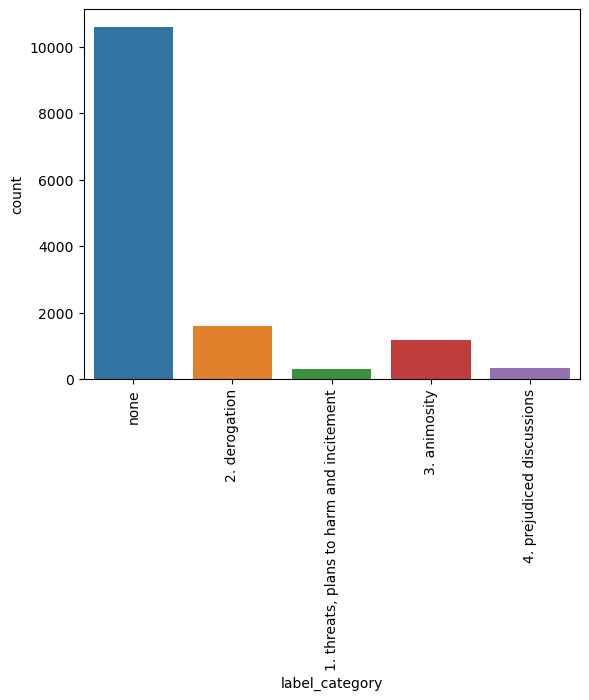

In [8]:
def count_plot(df, name, key_count = key_for_task):
    print(df.info())
    sn.countplot(data=df, x=key_count)
    plt.xticks(rotation = 90)
    plt.savefig(name)
    plt.show()
    
count_plot(df,"distribution.svg")

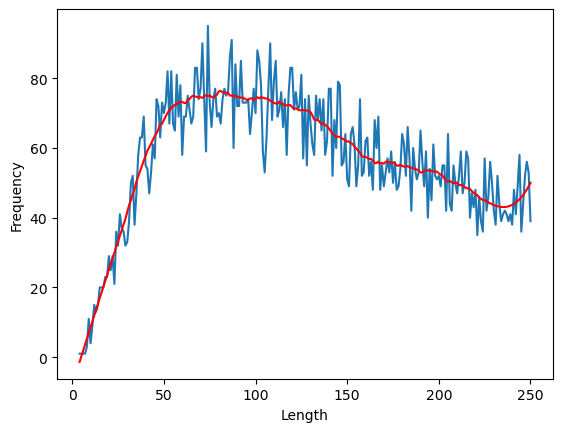

In [9]:
lens = df.text.str.len().value_counts()
count_plot = pd.DataFrame({'leng':lens.index, 'freq':lens.values}).sort_values('leng')
plt.plot(count_plot.leng,count_plot.freq)
plt.plot(count_plot.leng,savgol_filter(count_plot.freq, 51, 3), color='red')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

# **LABEL ENCODING**

In [10]:
label_encoder = LabelEncoder()

# label encoding

X = df['text']
Y = df[key_for_task]
Y = label_encoder.fit_transform(Y)

In [11]:
label_encoder_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_encoder_mapping)

NUM_CLASS = len(label_encoder_mapping)

{'1. threats, plans to harm and incitement': 0, '2. derogation': 1, '3. animosity': 2, '4. prejudiced discussions': 3, 'none': 4}


In [12]:
# one hot encoding

Y = tf.keras.utils.to_categorical(Y, num_classes=NUM_CLASS)

In [13]:
DEBUG_EPOCH = 10 # keep it 2, just to test notebook, before saving

EPOCH = DEBUG_EPOCH if is_interactive() else 180
print(EPOCH)

LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-2

10


# **SPLIT AND REGULARIZATION**

In [14]:
SHUFFLE_DS = 1024
BATCH_SIZE_DS = 16 * strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE

if task == 'a':
    train_X, val_X, train_Y, val_Y = train_test_split(X, Y, test_size=0.3, stratify=Y)
else:
    train_X, val_X, train_Y, val_Y = train_test_split(X, Y, test_size=0.3)
    
N_STEPS = len(train_X) / BATCH_SIZE_DS

In [15]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=10)
early_stopping_callback = EarlyStopping(monitor='val_loss',min_delta=0,patience=30,verbose=0, mode='auto')
model_saver = ModelCheckpoint(filepath='model.h5', save_best_only=True)

callbacks = [early_stopping_callback, lr_reducer,model_saver]

# **SENTENCE TRANSFORMATION**

In [16]:
# "sentence-transformers/all-MiniLM-L6-v2" <--- this one is the killer
## https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

class Sentence2Sentence(Layer):
    def __init__(self, **kwargs):
        super(Sentence2Sentence, self).__init__(**kwargs)

        pre_name = "sentence-transformers/all-MiniLM-L6-v2"
        self.tokenizer = AutoTokenizer.from_pretrained(pre_name)
        self.model = TFAutoModel.from_pretrained(pre_name)

        
    def tf_encode(self, inputs):
        def encode(inputs):
            inputs = [x[0].decode('utf-8') for x in inputs.numpy()]
            outputs = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='tf')
            return (outputs['input_ids'], outputs['token_type_ids'], outputs['attention_mask'])

        return tf.py_function(func=encode, inp=[inputs], Tout=[tf.int32, tf.int32, tf.int32])

    def process(self,i,t,a):

        def __call(i, t, a):
            model_output = self.model({'input_ids': i.numpy(),'token_type_ids': t.numpy(),'attention_mask': a.numpy()})
            return model_output[0]

        return tf.py_function(func=__call, inp=[i, t, a], Tout=[tf.float32])

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = tf.squeeze(tf.stack(model_output), axis=0)
        input_mask_expanded = tf.cast(tf.broadcast_to(tf.expand_dims(attention_mask, -1),tf.shape(token_embeddings)), tf.float32)
        a = tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1)
        b = tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)
        embeddings = a / b
        (embeddings, _) = tf.linalg.normalize(embeddings, 2, axis=1)
        return embeddings

    def call(self, inputs):
        (input_ids, token_type_ids, attention_mask) = self.tf_encode(inputs)
        input_ids.set_shape(tf.TensorShape((None, None)))
        token_type_ids.set_shape(tf.TensorShape((None, None)))
        attention_mask.set_shape(tf.TensorShape((None, None)))

        model_output = self.process(input_ids, token_type_ids,attention_mask)
        
        model_output[0].set_shape(tf.TensorShape((None, None, 384)))
        embeddings = self.mean_pooling(model_output, attention_mask)
        return embeddings

# **MODEL ARCHITECHTURE**

In [17]:
# "distilbert-base-uncased"
## https://huggingface.co/distilbert-base-uncased

class BertDistil(Layer):
    def __init__(self, **kwargs):
        super(BertDistil, self).__init__(**kwargs)

        pre_name = "distilbert-base-uncased"
        self.tokenizer = AutoTokenizer.from_pretrained(pre_name)
        self.model = TFAutoModel.from_pretrained(pre_name)

        
    def tf_encode(self, inputs):
        def encode(inputs):
            inputs = [x[0].decode('utf-8') for x in inputs.numpy()]
            outputs = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='tf')
            return (outputs['input_ids'], outputs['attention_mask'])

        return tf.py_function(func=encode, inp=[inputs], Tout=[tf.int32, tf.int32])

    def process(self,i,a):

        def __call(i, a):
            model_output = self.model({'input_ids': i.numpy(), 'attention_mask': a.numpy()})
            return model_output[0]

        return tf.py_function(func=__call, inp=[i, a], Tout=[tf.float32])

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = tf.squeeze(tf.stack(model_output), axis=0)
        input_mask_expanded = tf.cast(tf.broadcast_to(tf.expand_dims(attention_mask, -1),tf.shape(token_embeddings)), tf.float32)
        a = tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1)
        b = tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)
        embeddings = a / b
        (embeddings, _) = tf.linalg.normalize(embeddings, 2, axis=1)
        return embeddings

    def call(self, inputs):
        (input_ids, attention_mask) = self.tf_encode(inputs)
        input_ids.set_shape(tf.TensorShape((None, None)))
        attention_mask.set_shape(tf.TensorShape((None, None)))

        model_output = self.process(input_ids,attention_mask)
        
        model_output[0].set_shape(tf.TensorShape((None, None, 768)))
        embeddings = self.mean_pooling(model_output, attention_mask)
        return embeddings

In [18]:
class StringLowerLayer(Layer):
    def __init__(self, **kwargs):
        super(StringLowerLayer, self).__init__(**kwargs)
        
    def call(self, inputs):
        return tf.strings.lower(inputs)

In [19]:
class StressLayer(Layer):
    def __init__(self, **kwargs):
        super(StressLayer, self).__init__(**kwargs)

In [20]:
def get_model():
    text_input = Input(shape=(1,), dtype=tf.string,)
    
    
    
    x = Sentence2Sentence()(text_input)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(NUM_CLASS, activation='softmax')(x)
    
    
    
    y = BertDistil()(text_input)
    y = Dropout(0.5)(y)
    y = Dense(512, activation='relu')(y)
    y = Dropout(0.5)(y)
    y = Dense(256, activation='relu')(y)
    y = Dropout(0.5)(y)
    y = Dense(64, activation='relu')(y)
    y = Dense(NUM_CLASS, activation='softmax')(y)
    
    
    x = Add()([x,y])
    

    model = Model(inputs=[text_input], outputs = [x])
    return model

In [23]:
with strategy.scope():
    model = get_model()
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(
        loss=CategoricalCrossentropy(from_logits=True),
        optimizer=optimizer,
        metrics=[
            'accuracy',
            F1Score(num_classes=NUM_CLASS,average='macro'),
        ],
    )

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 bert_distil_1 (BertDistil)     (None, 768)          66362880    ['input_2[0][0]']                
                                                                                                  
 dropout_83 (Dropout)           (None, 768)          0           ['bert_distil_1[0][0]']          
                                                                                                  
 sentence2_sentence_1 (Sentence  (None, 384)         22713216    ['input_2[0][0]']                
 2Sentence)                                                                                 

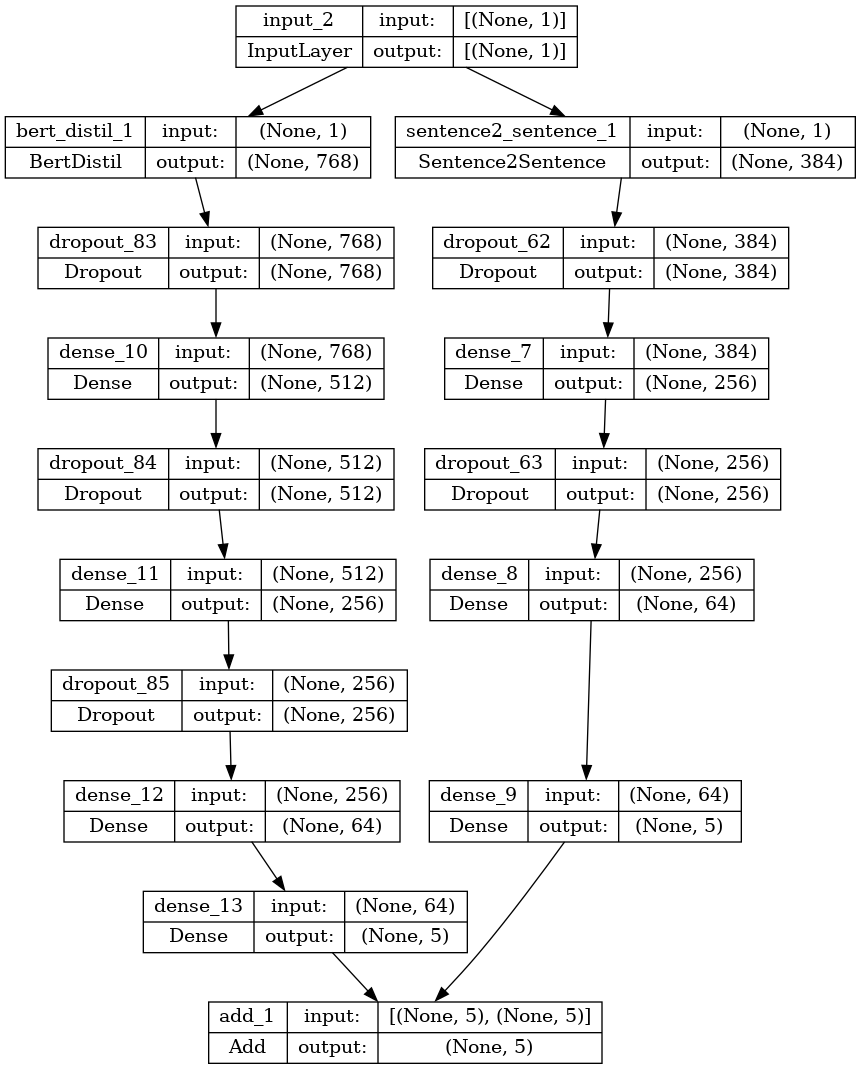

In [25]:
tf.keras.utils.plot_model(model, to_file='model.png',expand_nested=True,show_shapes=True,dpi=None,)

# **MODEL INFERENCE**

In [26]:
history_model = model.fit(train_X, train_Y,epochs=EPOCH,validation_data=(val_X, val_Y), callbacks=callbacks, steps_per_epoch = N_STEPS)

Epoch 1/10
612/612 [==============================] - 164s 261ms/step - loss: 1.1179 - accuracy: 0.7437 - f1_score: 0.1805 - val_loss: 0.9379 - val_accuracy: 0.7600 - val_f1_score: 0.1727 - lr: 5.0000e-05
Epoch 2/10
612/612 [==============================] - 144s 236ms/step - loss: 0.9302 - accuracy: 0.7561 - f1_score: 0.1722 - val_loss: 0.9173 - val_accuracy: 0.7600 - val_f1_score: 0.1727 - lr: 5.0000e-05
Epoch 3/10
612/612 [==============================] - 143s 233ms/step - loss: 0.9231 - accuracy: 0.7561 - f1_score: 0.1722 - val_loss: 0.9144 - val_accuracy: 0.7600 - val_f1_score: 0.1727 - lr: 5.0000e-05
Epoch 4/10
612/612 [==============================] - 160s 261ms/step - loss: 0.9216 - accuracy: 0.7561 - f1_score: 0.1722 - val_loss: 0.9135 - val_accuracy: 0.7600 - val_f1_score: 0.1727 - lr: 5.0000e-05
Epoch 5/10
612/612 [==============================] - 164s 267ms/step - loss: 0.9210 - accuracy: 0.7561 - f1_score: 0.1722 - val_loss: 0.9131 - val_accuracy: 0.7600 - val_f1_score:

In [27]:
!mkdir history

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [28]:
with open('history/history.json','w') as f:
    f.write(str(history_model.history))

In [29]:
!mkdir figures

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


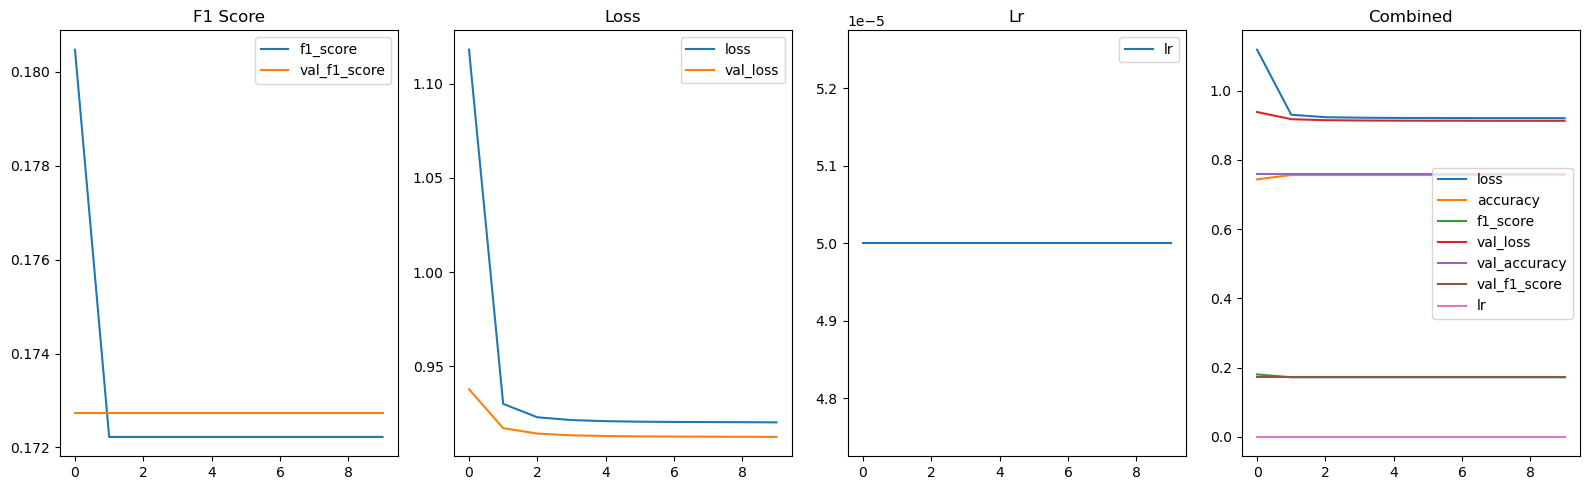

In [30]:
def captilize(string):
    string = string.replace("_"," ")
    return string.title()
    
    
def plot_graphs(data, keys):
    fig, axes = plt.subplots(1, (len(keys) + 1) , figsize=(16, 5))
    plt.legend(loc='best')
    
    for i in range(len(keys)):
        df_graph = pd.DataFrame({x:data[x] for x in data if keys[i] in x})
        df_keys = [x for x in data if keys[i] in x]
        df_graph[df_keys].plot(ax=axes[i])
        axes[i].set_title(captilize(keys[i]))
        
    last_index = len(keys)
    all_keys = [x for x in data if x]
    
    df_combined = pd.DataFrame({x: data[x] for x in data})
    df_combined[all_keys].plot(ax=axes[last_index])
    axes[len(keys)].set_title('Combined')
    
    plt.tight_layout()
    
    plt.savefig('figures/figure_optimizer.svg')
    plt.show()
        
plot_graphs(data = history_model.history, keys= ['f1_score','loss', 'lr'])